In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

current_directory = "/content/gdrive/My Drive/Seelk/"
csv_name = 'Seelk+Data+Science+Hackathon.csv'

Mounted at /content/gdrive


In [4]:
import pandas as pd
import math
import numpy as np
from tqdm import tqdm
!pip install price-parser
!pip install currencyconverter

Loading csv

Dropping NaN values and duplicate rows

Dropping the rows, where the price is missing

In [0]:
df = pd.read_csv(current_directory + csv_name, delimiter=';')
df = df.drop_duplicates()
df = df.dropna()
df = df.drop(df[df['price_currency'] == 'None'].index)

In [0]:
df.info()

Transforming both seller names and buy box owner names to uppercase

In [0]:
df['seller_name'] = df['seller_name'].apply(lambda x: x.upper())
df['buy_box_owner'] = df['buy_box_owner'].apply(lambda x: x.upper())

Since the 'buy_box_owner' column contains not only the name, but also other text, we determine if the seller is the one who is the buy box owner by checking if the seller's name is in the 'buy_box_owner' string

In [0]:
def who_sold(row):
  if row['seller_name'] in row['buy_box_owner']:
    row['sold'] = 1
  else:
    row['sold'] = 0
  return row

df = df.apply(who_sold, axis = 1)

Transforming the data from 'price_currency' column into form 'price' (float) and 'currency' (string). The library is used since the form of the text is different and use of different separators (',' , '.')
Same is applied to 'shipping_price' with the difference in that 'None' values are intepreted as 0's. 

In [0]:
from price_parser import Price
def price_to_float(row):
  price = Price.fromstring(row['price_currency'])
  row['currency'], row['price'] = price.currency,price.amount_float 
  return row  

df = df.apply(price_to_float, axis = 1)

In [0]:
def delivery_price_currency(row):
  if row['shipping_cost'] == 'None':
    row['shipping_currency'], row['shipping_price'] = row['currency'], 0
  else:
    price = Price.fromstring(row['shipping_cost'])
    row['shipping_currency'], row['shipping_price'] = price.currency,price.amount_float 
  return row  

df = df.apply(delivery_price_currency, axis = 1)

To use the prices we need to convert them, if the currency used is not EUR. To get the most precise convertion rates we use the library which allows us to access the convertion rates on the date.

In [0]:
df['currency'].value_counts()
dict_currency = {'EUR': 'EUR', '£' : 'GBP', '$' : 'USD'}
df['currency'] = df['currency'].apply(lambda x : dict_currency[x])
df['shipping_currency'] = df['shipping_currency'].apply(lambda x : dict_currency[x])


In [0]:
from datetime import datetime
from currency_converter import CurrencyConverter
c = CurrencyConverter(fallback_on_missing_rate=True)

def to_one_currency(row):
  row['new_price'] = c.convert(row['price'], row['currency'], 'EUR', datetime.strptime(row['scraping_date'], "%Y-%m-%d"))
  row['new_shipping_price'] = c.convert(row['shipping_price'], row['shipping_currency'], 'EUR', datetime.strptime(row['scraping_date'], "%Y-%m-%d"))
  return row

df = df.apply(to_one_currency, axis = 1)

In [0]:
export_csv = df.to_csv (current_directory + 'export_dataframe.csv', index = None, header=True)

Using regular expression we transform the 'rating_text' into 3 separate values:

1) Stars

2) Percentage of positive ratings

3) Number of positive ratings

In [0]:
import re

def rating(row):
  values = re.findall(r'-?\d+\.?\d*', row['rating_text'])
  if len(values) == 0:
    row['stars'] = -1
    row['positive_percentage'] = -1
    row['positive'] = -1
  else:
    values = np.array(values, dtype=np.float32)
    row['stars'] = values[0] / values[1]
    row['positive_percentage'] = values[2]
    row['positive'] = values[3]
  return row

df = df.apply(rating, axis = 1)

In [0]:
df = pd.read_csv(current_directory + 'export_dataframe.csv')

To use the price and shipping price we need to preprocess them. My decision to use both standardization and normalization is based on:

1) Normalization (Z-score) allows us to transform values into values between 0 and 1. This allows us to well represent minimum and maximum for each (scraping_date, offer) group

2) Standardization makes the mean of 'price' and 'shipping_price' equal to zero, as well as standard deviation equal to 1. This allows to show how much less (or more) expensive the product is. However, the hypothesis is that for more expensive products the difference is bigger, so the influence is higher. 

In [0]:
def standardization(df):
    groups = df.groupby(['scraping_date', 'offer'])
    mean = groups['new_price'].transform('mean')
    std = groups['new_price'].transform('std')
    mean_shipping = groups['new_shipping_price'].transform('mean')
    std_shipping = groups['new_shipping_price'].transform('std')
    df['standardization_shipping_price'] = (df['new_shipping_price'] - mean_shipping) / std_shipping
    df['standardization_price'] = (df['new_price'] - mean) / std  
    return df

In [0]:
def normalization(df):
    groups = df.groupby(['scraping_date', 'offer'])
    max_price = groups['new_price'].transform('max')
    min_price = groups['new_price'].transform('min')
    max_price_shipping = groups['new_shipping_price'].transform('max')
    min_price_shipping = groups['new_shipping_price'].transform('min')
    df['normalization_shipping_price'] = (df['new_shipping_price'] - min_price_shipping) / (max_price_shipping - min_price_shipping)
    df['normalization_price'] = (df['new_price'] - min_price) / (max_price - min_price)  
    return df

In [0]:
df = normalization(df)
df = standardization(df)

Dropping NaN rows again (for the offers with only one seller)

In [0]:
df = df.dropna()

Feature and target vectors

In [0]:
X = df[['offer_ranking', 'normalization_price', 'normalization_shipping_price', 'standardization_price', 'standardization_shipping_price', 'is_prime', 'is_global_store', 'stars', 'positive', 'positive_percentage']]
y = df[['sold']]

In [0]:
X = np.array(X)
y = np.array(y)

The use of StratifiedShuffleSplit allows us to have same percentage of each class in train and test data

In [0]:
random_state = 13
from sklearn.model_selection import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
for train_idx, test_idx in stratSplit.split(X, y):
    X_train=X[train_idx]
    y_train=y[train_idx].ravel()
    X_test=X[test_idx]
    y_test=y[test_idx].ravel()

The most used methods for binary classification are

1) Logistic Regression

2) Support Vector Machine (SVM)

3) Decision Tree

4) Random Forest

Random Forest is a black-box which does not allow us to really understand the importance of variables

### Logistic Regression
To check the performance we split train data once again into train and validation and perform cross validation. Since the data is highly imbalanced we specify class_weight='balanced'
F1 score is used for the same reason

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

f1_lr_scores = []
clfs_lr = []

stratSplit = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)

for train_idx, valid_idx in stratSplit.split(X_train, y_train):
    new_X_train=X_train[train_idx]
    new_y_train=y_train[train_idx]
    X_valid=X[valid_idx]
    y_valid=y[valid_idx].ravel()

    clf_lr = LogisticRegression(random_state=random_state, solver='saga', max_iter = 1000, class_weight='balanced').fit(new_X_train, new_y_train)
    f1_lr_scores.append(f1_score(y_valid, clf_lr.predict(X_valid), average='binary'))
    clfs_lr.append(clf_lr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

In [20]:
print('Average performance (F1 score) on validation set of logistic regression classifier:', np.mean(f1_lr_scores))
print('Best performance on validation set', np.max(f1_lr_scores))
print('Performance on test set', f1_score(y_test, clfs_lr[np.argmax(f1_lr_scores)].predict(X_test), average='binary'))

Average performance (F1 score) on validation set of logistic regression classifier: 0.2520458643339068
Best performance on validation set 0.2638937609621649
Performance on test set 0.25038931235144657


We can cocnlude that logistic regression is not the best suitable method for this task





### SVM

In [0]:
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', class_weight='balanced').fit(X_train, y_train)

In [34]:
f1_score(y_train, clf_svc.predict(X_train), average='binary')

0.3817642583189702

We can cocnlude that logistic regression is not the best suitable method for this task, even though the results are better than LR

### Decision tree

In [0]:
from sklearn import tree

f1_tree_scores = []
clfs_tree = []

stratSplit = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)

for train_idx, valid_idx in stratSplit.split(X_train, y_train):
    new_X_train=X_train[train_idx]
    new_y_train=y_train[train_idx]
    X_valid=X[valid_idx]
    y_valid=y[valid_idx]

    clf_tree = tree.DecisionTreeClassifier(class_weight = 'balanced').fit(new_X_train,  new_y_train)
    f1_tree_scores.append(f1_score(y_valid, clf_tree.predict(X_valid), average='binary'))
    clfs_tree.append(clf_tree)


In [32]:
print('Average performance (F1 score) on validation set of decision tree classifier:', np.mean(f1_tree_scores))
print('Best performance on validation set', np.max(f1_tree_scores))
print('Performance on test set', f1_score(y_test, clfs_tree[np.argmax(f1_tree_scores)].predict(X_test), average='binary'))

Average performance (F1 score) on validation set of decision tree classifier: 0.8269584414095092
Best performance on validation set 0.8332535503430668
Performance on test set 0.7102414654454622


Decision trees shows the best results

Let's check if we can increase the performance by fine-tuning

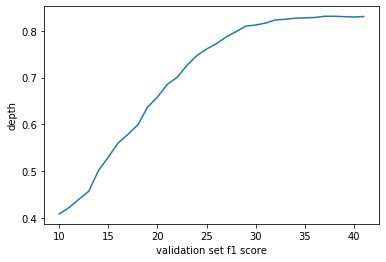

In [38]:
stratSplit = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
f1_tree_scores = []
for train_idx, valid_idx in stratSplit.split(X_train, y_train):
    new_X_train=X_train[train_idx]
    new_y_train=y_train[train_idx]
    X_valid=X[valid_idx]
    y_valid=y[valid_idx]

for i in range(10, 42):
  clf_tree = tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = i).fit(new_X_train,  new_y_train)
  f1_tree_scores.append(f1_score(y_valid, clf_tree.predict(X_valid), average='binary'))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(range(10,42)), f1_tree_scores)
plt.xlabel('validation set f1 score')
plt.ylabel('depth')
plt.show()

Maximum depth is the best depth

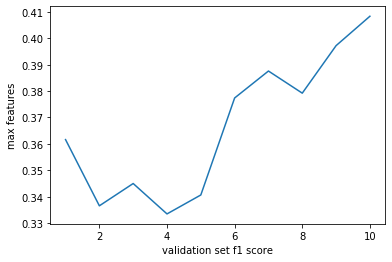

In [39]:
stratSplit = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
f1_tree_scores = []
for train_idx, valid_idx in stratSplit.split(X_train, y_train):
    new_X_train=X_train[train_idx]
    new_y_train=y_train[train_idx]
    X_valid=X[valid_idx]
    y_valid=y[valid_idx]

for i in range(1, 11):
  clf_tree = tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = i).fit(new_X_train,  new_y_train)
  f1_tree_scores.append(f1_score(y_valid, clf_tree.predict(X_valid), average='binary'))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(range(1, 11)), f1_tree_scores)
plt.xlabel('validation set f1 score')
plt.ylabel('max features')
plt.show()

The maximum length of 10 gives us the best performance

In [0]:
feature_names = ['offer_ranking', 'normalization_price', 'normalization_shipping_price', 'standardization_price', 'standardization_shipping_price', 'is_prime', 'is_global_store', 'stars', 'positive', 'positive_percentage']
clf_tree = tree.DecisionTreeClassifier(class_weight = 'balanced').fit(X_train, y_train)
feature_importances = clf_tree.feature_importances_
color_list = ['r','g','b','m','c','y','k', 'b','r', 'g']

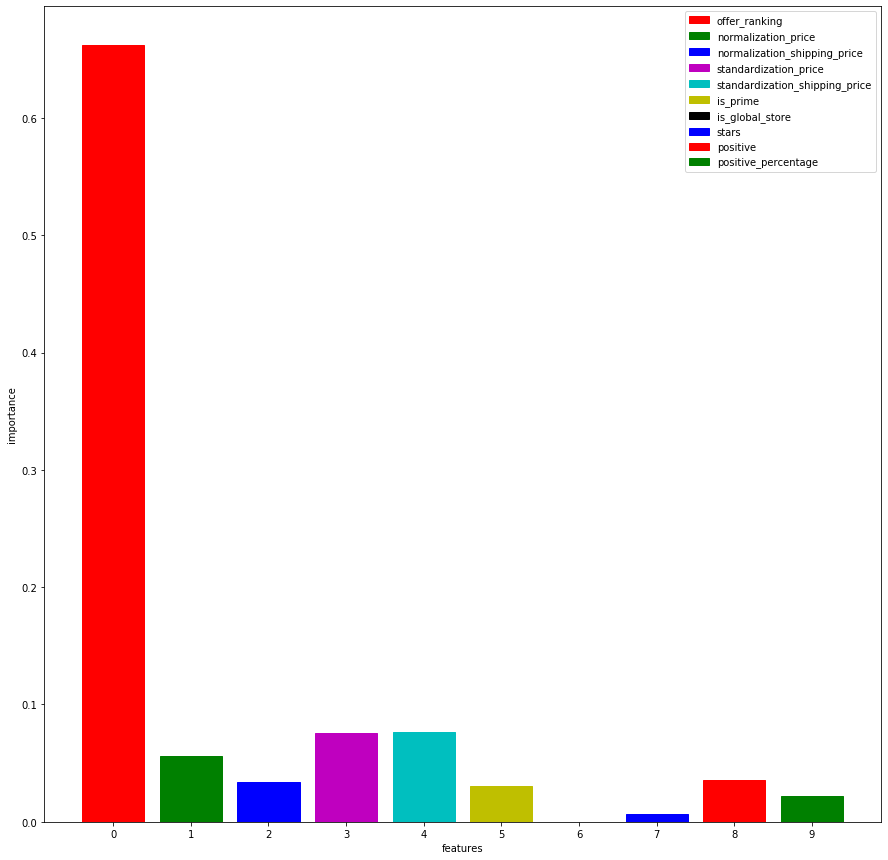

In [59]:
plt.figure(figsize = (15, 15))
bars = plt.bar(list(range(10)),feature_importances)
for i in range(len(bars)):
  bars[i].set_color(color_list[i])
plt.xticks(list(range(10)))
plt.legend(bars, feature_names)
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

As we can see the most important feature by far is 'ranking', followed by 'price'